<a href="https://colab.research.google.com/github/gskumlehn/autism-info-llm-comparison/blob/main/network_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Carregar bibliotecas
library(readr)
library(dplyr)
library(tidyr)
library(tidytext)
library(igraph)
library(ggraph)
library(ggplot2)

install.packages("stopwords")  # só uma vez
library(stopwords)

# Carregar o dataset
dataset <- read_csv("data (1).csv")

# Visualizar as colunas
colnames(dataset)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Rows: 8 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): Questions, OMS, ChatGPT 4.0, ChatGPT Vision, ScholarGPT, Gemini, L...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Questions"         "OMS"               "ChatGPT 4.0"      
 [4] "ChatGPT Vision"    "ScholarGPT"        "Gemini"           
 [7] "Llama3"            "Bing AI (Copilot)" "Google Palm"      
[10] "Claude"            "ReKa Core"         "Solar Mini"

In [27]:
# Transforma em formato longo: cada rede com suas respostas unificadas
responses <- dataset %>%
  pivot_longer(cols = -Questions, names_to = "network", values_to = "text") %>%
  group_by(network) %>%
  summarise(text = paste(text, collapse = " "), .groups = 'drop')


In [28]:
stopwords_en <- stopwords("en")
custom_stopwords <- c(stopwords_en, "asd")



top_words_per_network <- responses %>%
  unnest_tokens(word, text) %>%
  filter(!(word %in% custom_stopwords)) %>%  # remove preposições e outras stopwords em inglês
  count(network, word, sort = TRUE) %>%
  group_by(network) %>%
  top_n(15, n) %>%
  ungroup()


In [29]:
# Salvar o dataframe como CSV
write.csv(top_words_per_network, "top_words_per_network.csv", row.names = TRUE)


In [30]:
edges <- top_words_per_network %>%
  select(network, word) %>%
  rename(from = network, to = word)

graph <- graph_from_data_frame(edges, directed = FALSE)

V(graph)$type <- ifelse(V(graph)$name %in% responses$network, "Network", "Word")


Warning message:
“ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


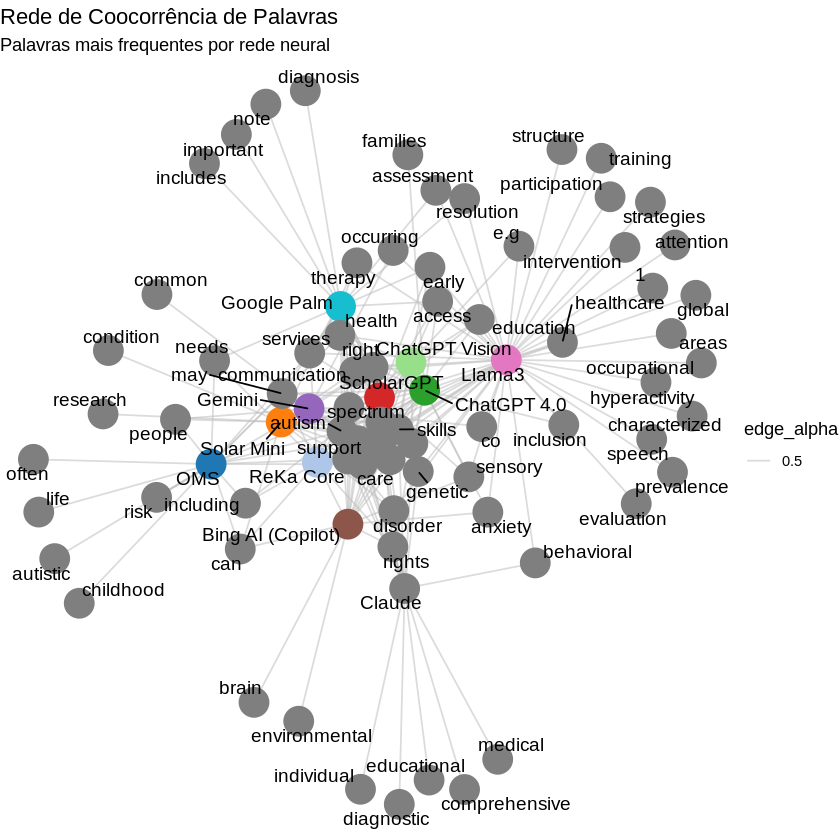

In [31]:
network_colors <- c(
  "OMS" = "#1f77b4", "ChatGPT 4.0" = "#2ca02c", "ChatGPT Vision" = "#98df8a",
  "ScholarGPT" = "#d62728", "Gemini" = "#9467bd", "Llama3" = "#e377c2",
  "Bing AI (Copilot)" = "#8c564b", "Google Palm" = "#17becf",
  "Claude" = "#7f7f7f", "ReKa Core" = "#aec7e8", "Solar Mini" = "#ff7f0e"
)

word_color <- "darkorange"

node_colors <- ifelse(V(graph)$name %in% names(network_colors),
                      network_colors[V(graph)$name], word_color)

# Plotar a rede
ggraph(graph, layout = "fr") +
  geom_edge_link(aes(edge_alpha = 0.5), color = "gray") +
  geom_node_point(aes(color = name), size = 8, show.legend = FALSE) +
  geom_node_text(aes(label = name), repel = TRUE, size = 4) +
  scale_color_manual(values = c(network_colors, word = word_color)) +
  theme_void() +
  labs(title = "Rede de Coocorrência de Palavras",
       subtitle = "Palavras mais frequentes por rede neural")
